# Mini Project 2: Neural Network with Nonlinear Least Squares #
### Name: Fei Yin ### 
### PID: A15555426 ###

In this project, we will approximate two nonlinear equations with neural network by solving nonlinear least squares problems. During the process, we will explore various initial conditions. Finally, we will evaluate the performances of the approximations.

In [1]:
import math
import random
import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import pinv
from prettytable import PrettyTable

We are given a function:
$\hat{y} = f_W(x) = w_1\phi(w_2x_1 + w_3x_2 + w_4x_3 + w_5) + w_6\phi(w_7x_1 + w_8x_2 + w_9x_3 + w_{10}) + w_{11}\phi(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15}) + w_{16}$, where $\phi(x)$ is a sigmoid function, $\frac{e^x - e^{-x}}{e^x + e^{-x}}$, x's are data points, and w's are coefficients that we want to find that allows us to approximate various equations.

(1) $\nabla_W{f_W(x)}$ is a column vector of partial derivatives of $f_W(x)$ with respect to each of $w_1 ... w_{16}$

$$\nabla_W{f_W(x)} = 
\begin{bmatrix}
\frac{\partial{f_W(x)}}{\partial{w_1}}\\
\frac{\partial{f_W(x)}}{\partial{w_2}}\\
\frac{\partial{f_W(x)}}{\partial{w_3}}\\
\frac{\partial{f_W(x)}}{\partial{w_4}}\\
\frac{\partial{f_W(x)}}{\partial{w_5}}\\
\frac{\partial{f_W(x)}}{\partial{w_6}}\\
\frac{\partial{f_W(x)}}{\partial{w_7}}\\
\frac{\partial{f_W(x)}}{\partial{w_8}}\\
\frac{\partial{f_W(x)}}{\partial{w_9}}\\
\frac{\partial{f_W(x)}}{\partial{w_{10}}}\\
\frac{\partial{f_W(x)}}{\partial{w_{11}}}\\
\frac{\partial{f_W(x)}}{\partial{w_{12}}}\\
\frac{\partial{f_W(x)}}{\partial{w_{13}}}\\
\frac{\partial{f_W(x)}}{\partial{w_{14}}}\\
\frac{\partial{f_W(x)}}{\partial{w_{15}}}\\
\frac{\partial{f_W(x)}}{\partial{w_{16}}}\\
\end{bmatrix} 
= 
\begin{bmatrix}
\phi(w_2x_1 + w_3x_2 + w_4x_3 + w_5)\\
w_1\phi'(w_2x_1 + w_3x_2 + w_4x_3 + w_5)x_1\\
w_1\phi'(w_2x_1 + w_3x_2 + w_4x_3 + w_5)x_2\\
w_1\phi'(w_2x_1 + w_3x_2 + w_4x_3 + w_5)x_3\\
w_1\phi'(w_2x_1 + w_3x_2 + w_4x_3 + w_5)\\
\phi(w_7x_1 + w_8x_2 + w_9x_3 + w_{10})\\
w_6\phi'(w_7x_1 + w_8x_2 + w_9x_3 + w_{10})x_1\\
w_6\phi'(w_7x_1 + w_8x_2 + w_9x_3 + w_{10})x_2\\
w_6\phi'(w_7x_1 + w_8x_2 + w_9x_3 + w_{10})x_3\\
w_6\phi'(w_7x_1 + w_8x_2 + w_9x_3 + w_{10})\\
\phi(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15})\\
w_{11}\phi'(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15})x_1\\
w_{11}\phi'(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15})x_2\\
w_{11}\phi'(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15})x_3\\
w_{11}\phi'(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15})\\
1\\
\end{bmatrix}$$

(2) Given $r_n(W) = f_W(x^{(n)}) - y^{(n)}$ and $r(W) = [r_1(W), ..., r_N(W)]$, $Dr(W)$ is a Jacobian matrix with size = N x n where each row is $\nabla_W{f_W(x^{(n)})^T}$. Since $y^{(n)}$ is not a function of $W$, it does not appear in $Dr(W)$.

$Dr(W) = 
\begin{bmatrix}
\frac{\partial{f_W(x^{(1)})}}{\partial{w_1}} & \dots & \frac{\partial{f_W(x^{(1)})}}{\partial{w_{16}}}\\
\vdots & & \vdots\\
\frac{\partial{f_W(x^{(N)})}}{\partial{w_1}} & \dots & \frac{\partial{f_W(x^{(N)})}}{\partial{w_{16}}}\\
\end{bmatrix}
$

(3) We want to minimize the following training loss function with respect to w:

$$l(W) = \sum_{n=1}^{N}{r_n}^2(W) + \lambda{\|W\|_2}^2$$

Using the Levenberg-Marquardt Algorithm, we want to solve the following:

$$
\begin{split}
\min_{W} l(W) + \lambda'{\|W-W^k\|_2}^2 & = \min_{W} \sum_{n=1}^{N}{r_n}^2(W) + \lambda{\|W\|_2}^2 + \lambda'{\|W-W^k\|_2}^2\\
& = \min_{W} {\|r(W)\|_2}^2 + \lambda{\|W\|_2}^2 + \lambda'{\|W-W^k\|_2}^2\\
& \approx \min_{W} {\|\hat{r}(W;W^k)\|_2}^2 + \lambda{\|W\|_2}^2 + \lambda'{\|W-W^k\|_2}^2\\
& = \min_{W} {\|r(W^k) + Dr(W^k)(W - W^k)\|_2}^2 + \lambda{\|W\|_2}^2 + \lambda'{\|W-W^k\|_2}^2\\
\end{split}
$$

At this step, we can formulate the problem as a linear least squares problem and obtain its solution by solving its corresponding normal equation. 

Let:
$$
\begin{split}
A_1 = Dr(W^k) & \;\;\;\; & b_1 = Dr(W^k)W^k - r(W^k)\\
A_2 = I & \;\;\;\; & b_2 = 0\\
A_3 = I & \;\;\;\; & b_3 = W^k
\end{split}
$$

$$
\begin{split}
A =
\begin{bmatrix}
A_1\\
\sqrt{\lambda}A_2\\
\sqrt{\lambda'}A_3
\end{bmatrix}
\;\;\;\; b = 
\begin{bmatrix}
b_1\\
\sqrt{\lambda}b_2\\
\sqrt{\lambda'}b_3
\end{bmatrix}
\end{split}
$$

And the previous equation becomes:
$$
\begin{split}
\min_{W} {\|r(W^k) + Dr(W^k)(W - W^k)\|_2}^2 + \lambda{\|W\|_2}^2 + \lambda'{\|W-W^k\|_2}^2 & = \min_{W} {\|AW - B\|_2}^2\\
A^T A W & = A^T b\\
(Dr(W^k)^T Dr(W^k) + \lambda I + \lambda' I)W & = Dr(W^k)^T (Dr(W^k)W^k - r(W^k)) + \lambda' W^k\\ 
& = (Dr(W^k)^T Dr(W^k) + \lambda' I)W^k - Dr(W^k)^T r(W^k)
\end{split}
$$

$$
W = (Dr(W^k)^T Dr(W^k) + \lambda I + \lambda' I)^{-1} ((Dr(W^k)^T Dr(W^k) + \lambda' I)W^k - Dr(W^k)^T r(W^k))
$$

The above $W$ represents $W^{k+1}$ given $W^k$ as input. Certainly, $x$, $y$, $\lambda$, and $\lambda'$ are also needed. To realize the Levenberg-Marquardt Algorithm, we first define several basic functions below: `norm`, `sigmoid`, and `sigmoid_d`. Note that `sigmoid_d` calculates the output of the sigmoid function's derivative defined as: $$ \phi'(x) = \frac{4}{e^{2x} + e^{-2x} + 2}$$

In [2]:
def norm(a):
    """Calculate the norm of a vector.

    Keyword arguments:
    a -- a (n x 1) matrix or (n, ) vector 
    
    Returns:
    norm_a -- a number representing the norm of a
    """
    
    norm_a = 0
    for i in range(len(a)):
        norm_a += a[i] ** 2
        
    return norm_a

In [3]:
def sigmoid(a):
    """Calculate the output of the sigmoid function given a number as input.

    Keyword arguments:
    a -- a number representing the input to the sigmoid function
    
    Returns:
    The output of the sigmoid function as a number
    """
    
    ## Setting upper bound and lower bound for a to avoid overflow error
    if a > 100:
        return 1
    
    elif a < -100:
        return -1
    
    else:
        return (math.exp(a) - math.exp(-1 * a)) / (math.exp(a) + math.exp(-1 * a))

In [4]:
def sigmoid_d(a):
    """Calculate the output of the sigmoid function's derivative given a number as input.

    Keyword arguments:
    a -- a number representing the input to the sigmoid function's derivative
    
    Returns:
    The output of the sigmoid function's derivative as a number
    """
    
    ## Setting upper bound and lower bound for a to avoid overflow erro
    if a > 100:
        return 0
    
    elif a < -100:
        return 0
    
    else:
        return 4 / (math.exp(2 * a) + math.exp(-2 * a) + 2)

Next, we define functions `calculate_f` and `calculate_r` to realize $f_W(x)$ and $r(W)$ respectively.

In [5]:
def calculate_f(w, x):
    """Calculate the output of f given w and x as inputs.

    Keyword arguments:
    w -- a (16, 1) matrix representing the coefficients
    x -- a (n, 3) matrix representing n data vectors, each as a 3-vector  
    
    Returns:
    f -- a (n, 1) matrix representing the output of f
    """
    
    f = np.zeros((x.shape[0], 1))
    
    for i in range(x.shape[0]):
        f[i] = w[0] * sigmoid(w[1] * x[i, 0] + w[2] * x[i, 1] + w[3] * x[i, 2] + w[4]) \
             + w[5] * sigmoid(w[6] * x[i, 0] + w[7] * x[i, 1] + w[8] * x[i, 2] + w[9]) \
             + w[10] * sigmoid(w[11] * x[i, 0] + w[12] * x[i, 1] + w[13] * x[i, 2] + w[14]) + w[15]
        
    return f

In [6]:
def calculate_r(w, x, y):
    """Calculate the output of r given w, x, and y as inputs.

    Keyword arguments:
    w -- a (16, 1) matrix representing the coefficients
    x -- a (n, 3) matrix representing n data vectors, each as a 3-vector  
    y -- a (n, 1) matrix representing n labels, each as a number
    
    Returns:
    r -- a (n, 1) matrix representing the output of r
    """
    
    f = calculate_f(w, x)
    r = np.subtract(f, y)
    return r

Using `sigmoid` and `sigmoid_d`, we can also define the gradient of $f_W(x)$ with respect to $W$, or $\nabla_W{f_W(x)}$, by implementing `calculateGradientW`. Then, using `calculateGradientW`, we can define the Jacobian of $r(W)$, or $Dr(W)$, by implementing `calculateJacobianW`.

In [7]:
def calculateGradientW(w, x):
    """Calculate the gradient of f with respect to w.

    Keyword arguments:
    w -- a (16, 1) matrix representing the coefficients
    x -- a (n, 3) matrix representing n data vectors, each as a 3-vector  
    
    Returns:
    gradient -- a (16, 1) matrix representing the gradient of f with respect to w
    """
    
    gradient = np.zeros(16)
    gradient[0] = sigmoid(w[1] * x[0] + w[2] * x[1] + w[3] * x[2] + w[4])
    gradient[1] = w[0] * sigmoid_d(w[1] * x[0] + w[2] * x[1] + w[3] * x[2] + w[4]) * x[0]
    gradient[2] = w[0] * sigmoid_d(w[1] * x[0] + w[2] * x[1] + w[3] * x[2] + w[4]) * x[1]
    gradient[3] = w[0] * sigmoid_d(w[1] * x[0] + w[2] * x[1] + w[3] * x[2] + w[4]) * x[2]
    gradient[4] = w[0] * sigmoid_d(w[1] * x[0] + w[2] * x[1] + w[3] * x[2] + w[4])
    gradient[5] = sigmoid(w[6] * x[0] + w[7] * x[1] + w[8] * x[2] + w[9])
    gradient[6] = w[5] * sigmoid_d(w[6] * x[0] + w[7] * x[1] + w[8] * x[2] + w[9]) * x[0]
    gradient[7] = w[5] * sigmoid_d(w[6] * x[0] + w[7] * x[1] + w[8] * x[2] + w[9]) * x[1]
    gradient[8] = w[5] * sigmoid_d(w[6] * x[0] + w[7] * x[1] + w[8] * x[2] + w[9]) * x[2]
    gradient[9] = w[5] * sigmoid_d(w[6] * x[0] + w[7] * x[1] + w[8] * x[2] + w[9])
    gradient[10] = sigmoid(w[11] * x[0] + w[12] * x[1] + w[13] * x[2] + w[14])
    gradient[11] = w[10] * sigmoid_d(w[11] * x[0] + w[12] * x[1] + w[13] * x[2] + w[14]) * x[0]
    gradient[12] = w[10] * sigmoid_d(w[11] * x[0] + w[12] * x[1] + w[13] * x[2] + w[14]) * x[1]
    gradient[13] = w[10] * sigmoid_d(w[11] * x[0] + w[12] * x[1] + w[13] * x[2] + w[14]) * x[2]
    gradient[14] = w[10] * sigmoid_d(w[11] * x[0] + w[12] * x[1] + w[13] * x[2] + w[14])
    gradient[15] = 1
    
    return gradient

In [8]:
def calculateJacobianW(w, x):
    """Calculate the jacobian of r with respect to w
    (which is the same as calculating the jacobian of f with respect to w).

    Keyword arguments:
    w -- a (16, 1) matrix representing the coefficients
    x -- a (n, 3) matrix representing n data vectors, each as a 3-vector  
    
    Returns:
    jacobian -- a (n, 16) matrix representing the jacobian of r with respect to w
    """
    
    jacobian = np.zeros((x.shape[0], 16))
    
    for i in range(x.shape[0]):
        jacobian[i] = calculateGradientW(w, x[i])
        
    return jacobian

With all the above functions, we now implement the Levenberg-Marquardt Algorithm with the function `iterateLM`. We apply 4 stopping criteria:
1. When small residual (p. 393 on textbook), $\left\lVert r(W) \right\rVert^2$, is small enough (set to 0.001 in the applications)
2. When small optimality condition residual (p. 393 on textbook), $\left\lVert 2 Dr(W)^T r(W) \right\rVert^2$, is small enough (set to 100 in the applications)
3. When number of iteration is too large (set to 1000 in the applications)
4. (Optional) When $\lambda'$ is much larger or much smaller than the input $\lambda'$

In [9]:
def iterateLM(w, x, y, lamb, lamb_d, max_iter, min_residual, min_OCR, prune_by_lamb_d):
    """Apply the Levenberg-Marquardt Algorithm.

    Keyword arguments:
    w -- a (16, 1) matrix representing the coefficients
    x -- a (n, 3) matrix representing n data vectors, each as a 3-vector
    y -- a (n, 1) matrix representing n labels, each as a number
    lamb -- a number representing the weight of a regularizer that limits the size of
            the output w for every iteration. lamb does not change during the iterations.
    lamb_d -- a number representing the weight of a regularizer that limits the the 
              difference between the input and output w's. lamb_d changes every iteration.
    max_iter -- a number representing the max number of iteration allowed.
                Iteration breaks when number of iteration exceeds this value.
    min_residual -- a number representing the minimum number of residual (2-norm of r).
                    Iteration breaks when residual drops below this value.
    min_OCR -- a number representing the minimum optimality condition residual.
               Iteration breaks when optimality condition residual drops below this value.
    prune_by_lamb_d -- a boolean that decides whether or not to prune the iteration by lamb_d
                       value. If this variable is set to true, iterations breaks when lamb_d
                       exceeds the input lamb_d * 100 or drops below the input lamb_d / 100.
    
    Returns:
    w_new -- a (16, 1) matrix representing the output coefficients trained by the LM algorithm.
    training_loss -- an array of numbers representing the training loss after every iteration.
                     Its length is the actual number of iterations executed by the program.
    """
    
    iter_count = 0
    initial_lamb_d = lamb_d
    training_loss = []
    
    while iter_count < max_iter:
        #print('Iteration count: ', iter_count, ' lamb_d: ', lamb_d)
        
        r = calculate_r(w, x, y)
        
        ## Calculate the residual r
        norm_r = norm(r)
        #print('Residual: ', norm_r)
        
        if norm_r < min_residual:
            break
    
        ## Calculate the jacobian Dr
        Dr = calculateJacobianW(w, x)
        
        ## Calculate the optimality condition residual OCR
        OCR = norm(2 * Dr.T @ r)
        #print('Optimality condition residual: ', OCR)
        
        if OCR < min_OCR:
            break
    
        ## Solve the Linear Least Squares problem as an approximation to compute the tentative iterate
        DrTDr = Dr.T @ Dr
        w_new = pinv(DrTDr + np.eye(16) * lamb + np.eye(16) * lamb_d) @ ((DrTDr + np.eye(16) * lamb_d) @ w - Dr.T @ r)
        r_new = calculate_r(w_new, x, y)
    
        ## Check the tentative iterate
        norm_r_new = norm(r_new)
        if norm_r_new < norm_r:
            w = w_new
            lamb_d *= 0.8
            training_loss.append(norm_r_new + lamb * norm(w_new))
            
        else:
            lamb_d *= 2
            
        if prune_by_lamb_d and (lamb_d > (initial_lamb_d * 100) or lamb_d < (initial_lamb_d / 100)):
            break
            
        iter_count += 1
        
    return w_new, training_loss

Finally, the error metrics used for the training and testing results is defined as: $$ \frac{1}{N} \sum_{n=1}^{N}{|\frac{y^{(n)} - f_W(x^{(n)})}{y^{(n)}}|} $$ which is implemented by the `calculateError` function below. 

In [10]:
def calculateError(f, y):
    diff = np.subtract(y, f)
    return np.mean(abs(np.divide(diff, y)))

## Training y = x1x2 + x3 ##
This is the first equation we want to model. We start by generating 500 random 3-vectors as our data vectors. 

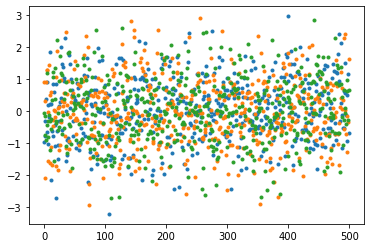

In [11]:
## Generate 500 random 3-vectors with numpy.random.randn
num_data = 500
x_train = np.random.randn(num_data, 3)

## Visualize data points
plt.plot(x_train[:, 0], '.')
plt.plot(x_train[:, 1], '.')
plt.plot(x_train[:, 2], '.')

We then calculate y, the labels, with the generated x values.

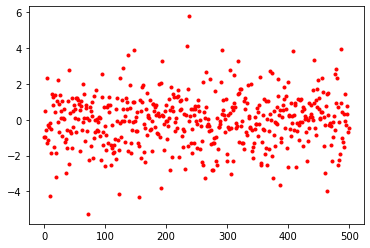

In [12]:
## Construct y
y_train = np.multiply(x_train[:, 0], x_train[:, 1]) + x_train[:, 2]
y_train = y_train.reshape(len(y_train), 1)

## Visualize labels
plt.plot(y_train, 'r.')

In order to roughly pick the best initial $\lambda$ and $\lambda'$, we permute across multiple choices of the two variables, run `iterateLM` 5 times for each, and calculate the average error for these 5 runs to represent the error resulted by each pair of $\lambda$ and $\lambda'$. Note that the initial w values are randomly picked with `np.random.randn`, the same function used to generate the data vectors x. `prune_by_lamb_d` is turned on here to save time.  

In [13]:
## Choose the lambdas we want to test
lambs = np.array([1e-25, 1e-20, 1e-15, 1e-10, 1e-5, 1, 1e5, 1e10, 1e15])
lambs_d = np.array([1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8])

In [14]:
errors = np.zeros((len(lambs), len(lambs_d)))
start_time = time.time()
num_trials_per_permutation = 5
training_losses_all = []

for i, lamb in enumerate(lambs):
    
    for j, lamb_d in enumerate(lambs_d):
        
        avg_error = 0
        training_losses_pair = []
                
        for k in tqdm.tqdm(range(num_trials_per_permutation), desc=('lambda: ' + str(lamb) \
                                                                    + ' lambda prime: ' + str(lamb_d)).ljust(60)):
            w = np.random.randn(16, 1)
            w_final, training_loss = iterateLM(w, x_train, y_train, lamb, lamb_d, 1000, 0.001, 100, True)
            training_losses_pair.append(training_loss)
            
            f_final = calculate_f(w_final, x_train)
            error = calculateError(f_final, y_train)
            avg_error += error
            
        avg_error /= num_trials_per_permutation
        errors[i, j] = avg_error
        training_losses_all.append(training_losses_pair)
        
print("--- %s seconds ---" % (time.time() - start_time))

lambda: 1e-25 lambda prime: 1e-08                           : 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
lambda: 1e-25 lambda prime: 1e-06                           : 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
lambda: 1e-25 lambda prime: 0.0001                          : 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]
lambda: 1e-25 lambda prime: 0.01                            : 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
lambda: 1e-25 lambda prime: 1.0                             : 100%|██████████| 5/5 [01:34<00:00, 18.88s/it]
lambda: 1e-25 lambda prime: 100.0                           : 100%|██████████| 5/5 [01:29<00:00, 17.83s/it]
lambda: 1e-25 lambda prime: 10000.0                         : 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
lambda: 1e-25 lambda prime: 1000000.0                       : 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
lambda: 1e-25 lambda prime: 100000000.0                     : 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
lambda: 1e-20 lambda prime: 

lambda: 1000000000000000.0 lambda prime: 0.01               : 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]
lambda: 1000000000000000.0 lambda prime: 1.0                : 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]
lambda: 1000000000000000.0 lambda prime: 100.0              : 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
lambda: 1000000000000000.0 lambda prime: 10000.0            : 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
lambda: 1000000000000000.0 lambda prime: 1000000.0          : 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
lambda: 1000000000000000.0 lambda prime: 100000000.0        : 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

--- 1200.84445810318 seconds ---


We can plot the training loss from each run, grouped by its corresponding pair of $\lambda$ and $\lambda'$. The plots are shown below. **Note:** Some plots are empty because their corresponding initial choices of $\lambda'$ cause the residual to never decrease. Consequently, no training loss was recorded. Some plots have only a few iterations because those runs are quickly terminated as `prune_by_lamb_d` is turned on.   

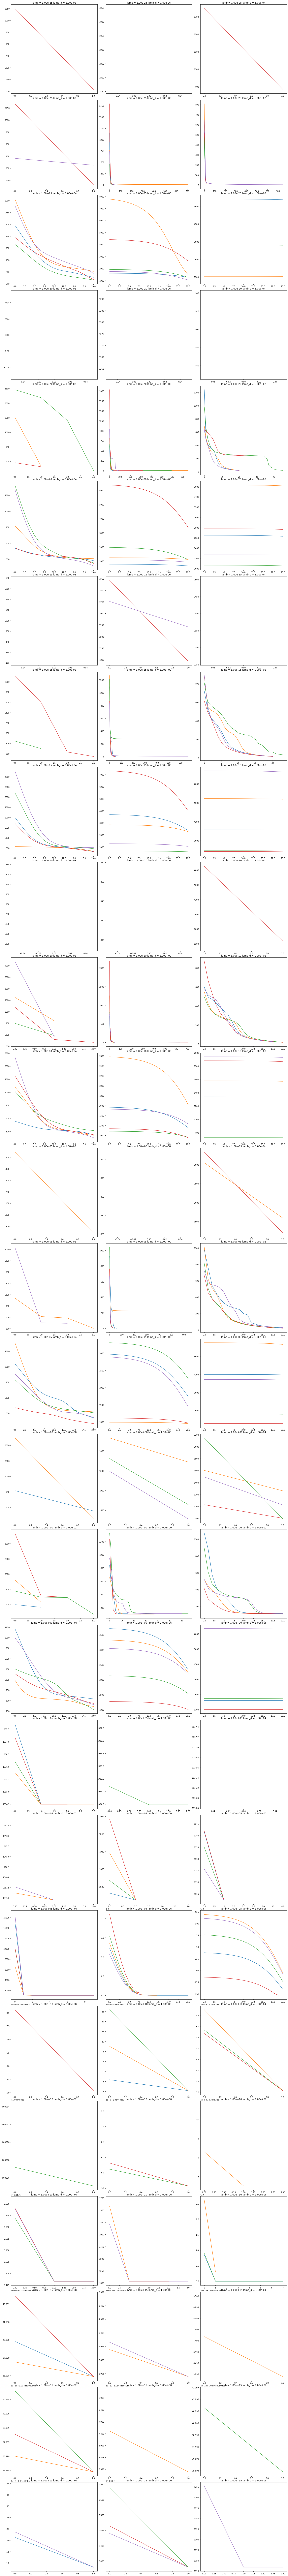

In [15]:
## Code for formating floats to strings in scientific notation comes from:
##     https://stackoverflow.com/questions/38847690/convert-float-to-string-in-positional-format-without-scientific-notation-and-fa

fig, axs = plt.subplots(27, 3, figsize=(20, 180))  
plt.tight_layout()

for i, training_losses_pair in enumerate(training_losses_all):
    for j, training_loss in enumerate(training_losses_pair):
        lamb_index = int(i / 9)
        lamb_d_index = i % 9
        axs[int(i / 3), i % 3].plot(training_loss)
        axs[int(i / 3), i % 3].set_title('lamb = ' + format(lambs[lamb_index], '.2e') \
                                         + ' lamb_d = ' + format(lambs_d[lamb_d_index], '.2e'))

After getting the average errors resulted by each pair of $\lambda$ and $\lambda'$, we construct a table showing all the errors with respect to each pair of $\lambda$ and $\lambda'$. From the table, we can decide what $\lambda$ and $\lambda'$ are roughly the best initial conditions for the function that we are modeling.

In [16]:
## Code for constructing a table with PrettyTable comes from: 
##     https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/
## Code for printing numbers in scientific notation comes from:
##     https://www.kite.com/python/answers/how-to-print-a-number-in-scientific-notation-in-python

error_table_header = ['{:.2e}'.format(a) for a in lambs_d.tolist()]
error_table_header.insert(0, 'lbs\lbs_d')
error_table = PrettyTable(error_table_header)

for i in range(len(lambs)):
    e = ['{:.2e}'.format(a) for a in errors[i].tolist()] 
    e.insert(0, '{:.2e}'.format(lambs[i]))
    error_table.add_row(e)

print(error_table)

+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| lbs\lbs_d | 1.00e-08 | 1.00e-06 | 1.00e-04 | 1.00e-02 | 1.00e+00 | 1.00e+02 | 1.00e+04 | 1.00e+06 | 1.00e+08 |
+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  1.00e-25 | 1.61e+03 | 3.07e+01 | 9.97e+00 | 4.90e+00 | 1.20e-01 | 3.21e-01 | 1.39e+00 | 3.94e+00 | 4.73e+00 |
|  1.00e-20 | 7.95e+00 | 2.11e+01 | 1.64e+01 | 8.99e+00 | 1.59e-01 | 5.48e-01 | 1.50e+00 | 3.23e+00 | 6.27e+00 |
|  1.00e-15 | 5.61e+01 | 1.53e+01 | 1.08e+01 | 7.76e+00 | 4.33e-01 | 3.44e-01 | 1.31e+00 | 3.68e+00 | 7.46e+00 |
|  1.00e-10 | 1.39e+01 | 8.71e+00 | 1.10e+01 | 4.04e+00 | 1.39e-01 | 3.65e-01 | 1.31e+00 | 2.34e+00 | 3.49e+00 |
|  1.00e-05 | 1.50e+01 | 2.51e+01 | 7.30e+00 | 6.56e+00 | 3.39e-01 | 4.03e-01 | 1.42e+00 | 3.75e+00 | 6.40e+00 |
|  1.00e+00 | 5.94e+00 | 4.01e+00 | 4.17e+00 | 5.53e+00 | 6.33e-01 | 6.30e-01 | 1.46e+00 | 3.47e

Choosing the $\lambda$ and $\lambda'$ that resulted in the smallest error from the tests above, we then run `iterateLM` 10 times and pick the final set of coefficients, w, that results in the smallest error. `prune_by_lamb_d` is turned off here.  

In [17]:
lamb = lambs[int(np.argmin(errors) / len(lambs_d))]
lamb_d = lambs_d[np.argmin(errors) % len(lambs_d)]
print("best lambda: ", lamb, ' best lambda prime: ', lamb_d)

best lambda:  1e-25  best lambda prime:  1.0


In [18]:
ws_final = np.zeros((16, 10))
errors = np.zeros((10, 1))
start_time = time.time()
training_losses = []

for k in tqdm.tqdm(range(10), desc='lambda: ' + str(lamb) + ' lambda prime: ' + str(lamb_d)):
    w = np.random.randn(16, 1)
    w_final, training_loss = iterateLM(w, x_train, y_train, lamb, lamb_d, 1000, 0.001, 100, False)
    training_losses.append(training_loss)
    ws_final[:, k] = w_final[:, 0]
    
    f_final = calculate_f(w_final, x_train)
    error = calculateError(f_final, y_train)
    
    print('Error: ', error, ' Final training loss: ', training_loss[-1])
    
    errors[k, 0] = error
    
print("--- %s seconds ---" % (time.time() - start_time))
print('Average error: ', np.mean(errors), ' Min error: ', np.min(errors), ' Max error: ', np.max(errors))

lambda: 1e-25 lambda prime: 1.0:  10%|█         | 1/10 [00:24<03:41, 24.63s/it]

Error:  0.029906489365111043  Final training loss:  [0.13868672]


lambda: 1e-25 lambda prime: 1.0:  20%|██        | 2/10 [00:45<03:06, 23.36s/it]

Error:  0.2054894131413092  Final training loss:  [5.18574828]


lambda: 1e-25 lambda prime: 1.0:  30%|███       | 3/10 [01:08<02:42, 23.28s/it]

Error:  0.013632444037060704  Final training loss:  [0.03125065]


lambda: 1e-25 lambda prime: 1.0:  40%|████      | 4/10 [01:16<01:53, 18.91s/it]

Error:  0.1553864288835271  Final training loss:  [3.03141316]


lambda: 1e-25 lambda prime: 1.0:  50%|█████     | 5/10 [01:41<01:42, 20.55s/it]

Error:  0.006019914812899074  Final training loss:  [0.00709114]


lambda: 1e-25 lambda prime: 1.0:  60%|██████    | 6/10 [02:09<01:31, 22.89s/it]

Error:  0.005504467874308684  Final training loss:  [0.00620555]


lambda: 1e-25 lambda prime: 1.0:  70%|███████   | 7/10 [03:19<01:51, 37.04s/it]

Error:  0.19153600762579995  Final training loss:  [4.56599847]


lambda: 1e-25 lambda prime: 1.0:  80%|████████  | 8/10 [03:42<01:05, 32.78s/it]

Error:  0.01352711058243418  Final training loss:  [0.03077401]


lambda: 1e-25 lambda prime: 1.0:  90%|█████████ | 9/10 [04:10<00:31, 31.45s/it]

Error:  0.005483300113413872  Final training loss:  [0.00614442]


lambda: 1e-25 lambda prime: 1.0: 100%|██████████| 10/10 [04:38<00:00, 27.86s/it]

Error:  0.005827600243244094  Final training loss:  [0.00664864]
--- 278.6414952278137 seconds ---
Average error:  0.0632313176679108  Min error:  0.005483300113413872  Max error:  0.2054894131413092


In [19]:
w_final = ws_final[:, np.argmin(errors)]

The plot below shows training loss vs iterations for the 10 runs. Notice that not all of the 10 runs give good results. Because we initialize w randomly, it is necessary that we run `iterateLM` multiple times with the same pair of $\lambda$ and $\lambda'$.

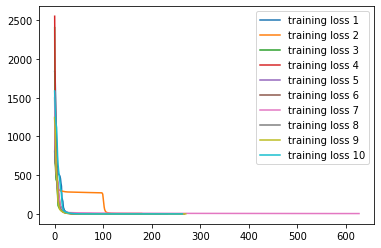

In [20]:
for i in range(len(training_losses)):
    plt.plot(training_losses[i], label='training loss ' + str(i + 1))
plt.legend()
plt.show()

## Testing y = x1x2 + x3 ##

After traininig the coefficients that model this equation, we now test its performance on different sets of data, with different number of data vectors. We create 3 new sets of data-vectors with size 50, 150, and 300, and corresponding set of labels for each. Note that the testing data-vectors are created in the same way as the training ones, using `np.random.randn`.

In [21]:
num_data_1 = 50
num_data_2 = 150
num_data_3 = 300

x1_test = np.random.randn(num_data_1, 3)
x2_test = np.random.randn(num_data_2, 3)
x3_test = np.random.randn(num_data_3, 3)

y1_test = np.multiply(x1_test[:, 0], x1_test[:, 1]) + x1_test[:, 2]
y2_test = np.multiply(x2_test[:, 0], x2_test[:, 1]) + x2_test[:, 2]
y3_test = np.multiply(x3_test[:, 0], x3_test[:, 1]) + x3_test[:, 2]

y1_test = y1_test.reshape(len(y1_test), 1)
y2_test = y2_test.reshape(len(y2_test), 1)
y3_test = y3_test.reshape(len(y3_test), 1)

We then apply the trained coefficients to calculate each $f_W(x)$ and its error with respect to the corresponding labels.

In [22]:
f1_test = calculate_f(w_final, x1_test)
f2_test = calculate_f(w_final, x2_test)
f3_test = calculate_f(w_final, x3_test)

e1_test = calculateError(f1_test, y1_test)
e2_test = calculateError(f2_test, y2_test)
e3_test = calculateError(f3_test, y3_test)

print('Average error for test set 1: ', e1_test)
print('Average error for test set 2: ', e2_test)
print('Average error for test set 3: ', e3_test)

Average error for test set 1:  0.0024933823275188603
Average error for test set 2:  0.006607119489747623
Average error for test set 3:  0.010009131458131603


The errors for 2 of the 3 test cases are slightly larger than the training error, but are mostly consistent, which means our model generalizes on the testing data pretty well. The error metrics (`calculateError`) used for the testing cases are the same as that of the training case. 

## Training y =  x1 (x2 - x3) ##

This is the second equation we want to model. Except for the labels being calculated differently, all code are identical as the code used for training the first equation. We again start by generating 500 random 3-vectors as our data vectors.

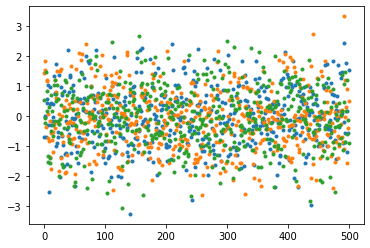

In [23]:
## Generate 500 random 3-vectors with numpy.random.randn
num_data = 500
x_train = np.random.randn(num_data, 3)

## Visualize data points
plt.plot(x_train[:, 0], '.')
plt.plot(x_train[:, 1], '.')
plt.plot(x_train[:, 2], '.')

We then calculate y, the labels, with the generated x values.

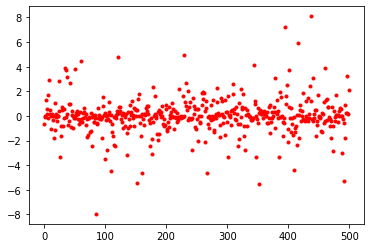

In [24]:
## Construct y
y_train = np.multiply(x_train[:, 0], np.subtract(x_train[:, 1], x_train[:, 2]))
y_train = y_train.reshape(len(y_train), 1)

## Visualize labels
plt.plot(y_train, 'r.')

In order to roughly pick the best initial $\lambda$ and $\lambda'$, we permute across multiple choices of the two variables, run `iterateLM` 5 times for each, and calculate the average error for these 5 runs to represent the error resulted by each pair of $\lambda$ and $\lambda'$. Note that the initial w values are randomly picked with `np.random.randn`, the same function used to generate the data vectors x. `prune_by_lamb_d` is turned on here to save time. 

In [25]:
## Choose the lambdas we want to test
lambs = np.array([1e-25, 1e-20, 1e-15, 1e-10, 1e-5, 1, 1e5, 1e10, 1e15])
lambs_d = np.array([1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8])

In [26]:
errors = np.zeros((len(lambs), len(lambs_d)))
start_time = time.time()
num_trials_per_permutation = 5
training_losses_all = []

for i, lamb in enumerate(lambs):
    
    for j, lamb_d in enumerate(lambs_d):
        
        avg_error = 0
        training_losses_pair = []
                
        for k in tqdm.tqdm(range(num_trials_per_permutation), desc=('lambda: ' + str(lamb) \
                                                                    + ' lambda prime: ' + str(lamb_d)).ljust(60)):
            w = np.random.randn(16, 1)
            w_final, training_loss = iterateLM(w, x_train, y_train, lamb, lamb_d, 1000, 0.001, 100, True)
            training_losses_pair.append(training_loss)
            
            f_final = calculate_f(w_final, x_train)
            error = calculateError(f_final, y_train)
            avg_error += error
            
        avg_error /= num_trials_per_permutation
        errors[i, j] = avg_error
        training_losses_all.append(training_losses_pair)
        
print("--- %s seconds ---" % (time.time() - start_time))

lambda: 1e-25 lambda prime: 1e-08                           : 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
lambda: 1e-25 lambda prime: 1e-06                           : 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
lambda: 1e-25 lambda prime: 0.0001                          : 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
lambda: 1e-25 lambda prime: 0.01                            : 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
lambda: 1e-25 lambda prime: 1.0                             : 100%|██████████| 5/5 [00:44<00:00,  8.82s/it]
lambda: 1e-25 lambda prime: 100.0                           : 100%|██████████| 5/5 [00:32<00:00,  6.58s/it]
lambda: 1e-25 lambda prime: 10000.0                         : 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]
lambda: 1e-25 lambda prime: 1000000.0                       : 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
lambda: 1e-25 lambda prime: 100000000.0                     : 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
lambda: 1e-20 lambda prime: 

lambda: 1000000000000000.0 lambda prime: 0.01               : 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
lambda: 1000000000000000.0 lambda prime: 1.0                : 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
lambda: 1000000000000000.0 lambda prime: 100.0              : 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
lambda: 1000000000000000.0 lambda prime: 10000.0            : 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
lambda: 1000000000000000.0 lambda prime: 1000000.0          : 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
lambda: 1000000000000000.0 lambda prime: 100000000.0        : 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

--- 935.988340139389 seconds ---


We can plot the training loss from each run, grouped by its corresponding pair of $\lambda$ and $\lambda'$. The plots are shown below. **Note:** Some plots are empty because their corresponding initial choices of $\lambda'$ cause the residual to never decrease. Consequently, no training loss was recorded. Some plots have only a few iterations because those runs are quickly terminated as `prune_by_lamb_d` is turned on.

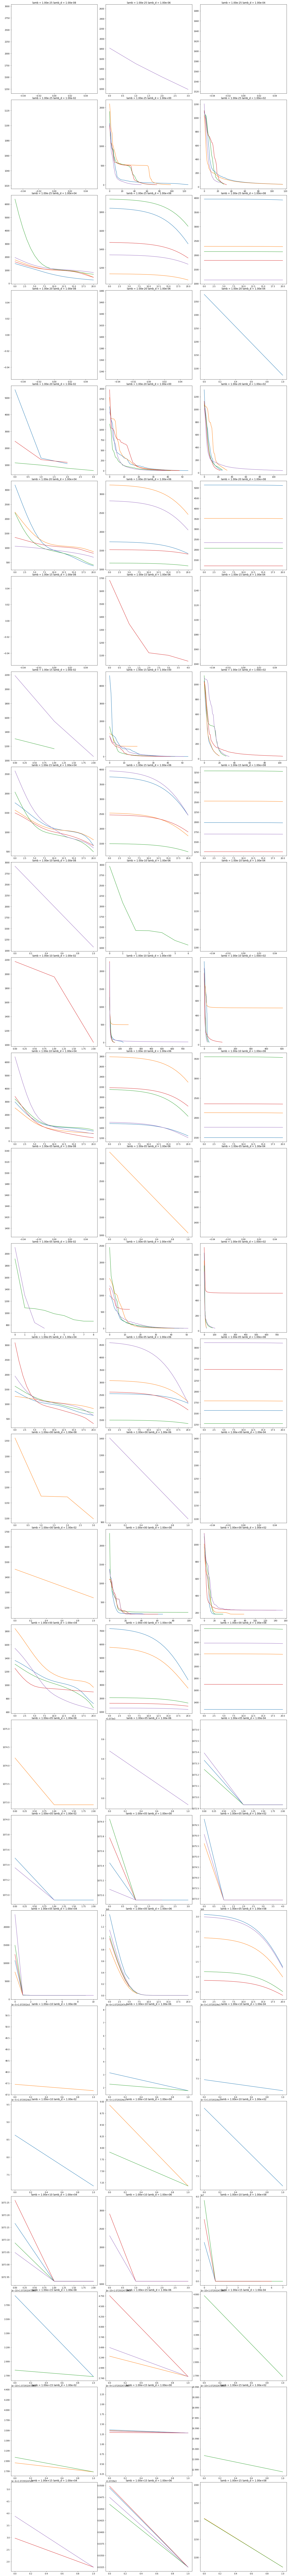

In [27]:
fig, axs = plt.subplots(27, 3, figsize=(20, 180))  
plt.tight_layout()

for i, training_losses_pair in enumerate(training_losses_all):
    for j, training_loss in enumerate(training_losses_pair):
        lamb_index = int(i / 9)
        lamb_d_index = i % 9
        axs[int(i / 3), i % 3].plot(training_loss)
        axs[int(i / 3), i % 3].set_title('lamb = ' + format(lambs[lamb_index], '.2e') \
                                         + ' lamb_d = ' + format(lambs_d[lamb_d_index], '.2e'))

After getting the average errors resulted by each pair of $\lambda$ and $\lambda'$, we construct a table showing all the errors with respect to each pair of $\lambda$ and $\lambda'$. From the table, we can decide what $\lambda$ and $\lambda'$ are roughly the best initial conditions for the function that we are modeling.

In [28]:
error_table_header = ['{:.2e}'.format(a) for a in lambs_d.tolist()]
error_table_header.insert(0, 'lbs\lbs_d')
error_table = PrettyTable(error_table_header)

for i in range(len(lambs)):
    e = ['{:.2e}'.format(a) for a in errors[i].tolist()] 
    e.insert(0, '{:.2e}'.format(lambs[i]))
    error_table.add_row(e)

print(error_table)

+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| lbs\lbs_d | 1.00e-08 | 1.00e-06 | 1.00e-04 | 1.00e-02 | 1.00e+00 | 1.00e+02 | 1.00e+04 | 1.00e+06 | 1.00e+08 |
+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  1.00e-25 | 1.31e+02 | 4.14e+01 | 1.25e+02 | 3.54e+01 | 5.33e-01 | 1.30e+00 | 4.59e+00 | 9.56e+00 | 2.11e+01 |
|  1.00e-20 | 6.75e+01 | 2.58e+02 | 7.82e+01 | 1.36e+01 | 5.15e-01 | 1.79e+00 | 6.69e+00 | 1.12e+01 | 2.53e+01 |
|  1.00e-15 | 5.70e+01 | 6.35e+01 | 7.48e+01 | 1.74e+01 | 8.62e-01 | 1.70e+00 | 5.42e+00 | 1.89e+01 | 2.00e+01 |
|  1.00e-10 | 1.05e+02 | 9.52e+01 | 4.34e+01 | 2.16e+01 | 2.59e+00 | 3.66e+00 | 5.23e+00 | 1.15e+01 | 2.24e+01 |
|  1.00e-05 | 1.61e+02 | 4.36e+01 | 4.23e+01 | 1.94e+01 | 8.77e-01 | 3.17e+00 | 7.39e+00 | 1.52e+01 | 1.54e+01 |
|  1.00e+00 | 2.79e+01 | 1.88e+01 | 1.89e+01 | 2.15e+01 | 4.13e+00 | 3.93e+00 | 6.65e+00 | 2.04e

Choosing the $\lambda$ and $\lambda'$ that resulted in the smallest error from the tests above, we then run `iterateLM` 10 times and pick the final set of coefficients, w, that results in the smallest error. `prune_by_lamb_d` is turned off here.  

In [29]:
lamb = lambs[int(np.argmin(errors) / len(lambs_d))]
lamb_d = lambs_d[np.argmin(errors) % len(lambs_d)]
print("best lambda: ", lamb, ' best lambda prime: ', lamb_d)

best lambda:  1e-20  best lambda prime:  1.0


In [30]:
ws_final = np.zeros((16, 10))
errors = np.zeros((10, 1))
start_time = time.time()
training_losses = []

for k in tqdm.tqdm(range(10), desc='lambda: ' + str(lamb) + ' lambda prime: ' + str(lamb_d)):
    w = np.random.randn(16, 1)
    w_final, training_loss = iterateLM(w, x_train, y_train, lamb, lamb_d, 1000, 0.001, 100, False)
    training_losses.append(training_loss)
    ws_final[:, k] = w_final[:, 0]
    
    f_final = calculate_f(w_final, x_train)
    error = calculateError(f_final, y_train)
    
    print('Error: ', error, ' Final training loss: ', training_loss[-1])
    
    errors[k, 0] = error
    
print("--- %s seconds ---" % (time.time() - start_time))
print('Average error: ', np.mean(errors), ' Min error: ', np.min(errors), ' Max error: ', np.max(errors))

lambda: 1e-20 lambda prime: 1.0:  10%|█         | 1/10 [00:53<07:58, 53.17s/it]

Error:  0.030611730654319345  Final training loss:  [0.00841748]


lambda: 1e-20 lambda prime: 1.0:  20%|██        | 2/10 [01:47<07:07, 53.47s/it]

Error:  0.03044572612926863  Final training loss:  [0.00832487]


lambda: 1e-20 lambda prime: 1.0:  30%|███       | 3/10 [03:11<07:18, 62.67s/it]

Error:  0.02264951881686827  Final training loss:  [0.01324085]


lambda: 1e-20 lambda prime: 1.0:  40%|████      | 4/10 [04:00<05:50, 58.50s/it]

Error:  0.0293739381517595  Final training loss:  [0.00775109]


lambda: 1e-20 lambda prime: 1.0:  50%|█████     | 5/10 [04:51<04:40, 56.19s/it]

Error:  0.031112370786445753  Final training loss:  [0.00867276]


lambda: 1e-20 lambda prime: 1.0:  60%|██████    | 6/10 [05:41<03:37, 54.45s/it]

Error:  0.03241417282630362  Final training loss:  [0.00939541]


lambda: 1e-20 lambda prime: 1.0:  70%|███████   | 7/10 [06:35<02:42, 54.28s/it]

Error:  0.030099443039040295  Final training loss:  [0.00812892]


lambda: 1e-20 lambda prime: 1.0:  80%|████████  | 8/10 [07:19<01:42, 51.21s/it]

Error:  0.030161756109674108  Final training loss:  [0.00815808]


lambda: 1e-20 lambda prime: 1.0:  90%|█████████ | 9/10 [08:12<00:51, 51.70s/it]

Error:  0.03024715052583669  Final training loss:  [0.00820811]


lambda: 1e-20 lambda prime: 1.0: 100%|██████████| 10/10 [09:03<00:00, 54.37s/it]

Error:  0.030950194168802028  Final training loss:  [0.00859278]
--- 543.7185127735138 seconds ---
Average error:  0.029806600120831823  Min error:  0.02264951881686827  Max error:  0.03241417282630362


In [31]:
w_final = ws_final[:, np.argmin(errors)]

The plot below shows training loss vs iterations for the 10 runs. Notice that not all of the 10 runs give good results. Because we initialize w randomly, it is necessary that we run `iterateLM` multiple times with the same pair of $\lambda$ and $\lambda'$.

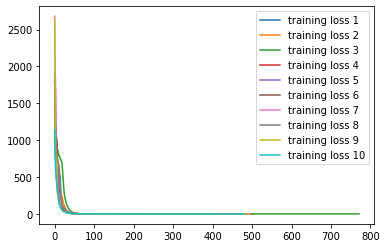

In [32]:
for i in range(len(training_losses)):
    plt.plot(training_losses[i], label='training loss ' + str(i + 1))
plt.legend()
plt.show()

## Testing y =  x1 (x2 - x3) ##

After traininig the coefficients that model this equation, we now test its performance on different sets of data, with different number of data vectors. We create 3 new sets of data-vectors with size 50, 150, and 300, and corresponding set of labels for each. Note that the testing data-vectors are created in the same way as the training ones, using `np.random.randn`.

In [33]:
num_data_1 = 50
num_data_2 = 150
num_data_3 = 300

x1_test = np.random.randn(num_data_1, 3)
x2_test = np.random.randn(num_data_2, 3)
x3_test = np.random.randn(num_data_3, 3)

y1_test = np.multiply(x1_test[:, 0], np.subtract(x1_test[:, 1], x1_test[:, 2]))
y2_test = np.multiply(x2_test[:, 0], np.subtract(x2_test[:, 1], x2_test[:, 2]))
y3_test = np.multiply(x3_test[:, 0], np.subtract(x3_test[:, 1], x3_test[:, 2]))

y1_test = y1_test.reshape(len(y1_test), 1)
y2_test = y2_test.reshape(len(y2_test), 1)
y3_test = y3_test.reshape(len(y3_test), 1)

We then apply the trained coefficients to calculate each $f_W(x)$ and its error with respect to the corresponding labels.

In [34]:
f1_test = calculate_f(w_final, x1_test)
f2_test = calculate_f(w_final, x2_test)
f3_test = calculate_f(w_final, x3_test)

e1_test = calculateError(f1_test, y1_test)
e2_test = calculateError(f2_test, y2_test)
e3_test = calculateError(f3_test, y3_test)

print('Average error for test set 1: ', e1_test)
print('Average error for test set 2: ', e2_test)
print('Average error for test set 3: ', e3_test)

Average error for test set 1:  0.034936905716283724
Average error for test set 2:  0.07230284083779037
Average error for test set 3:  0.023249499205874644


The errors for all 3 test cases are slightly larger than the training error, but are mostly consistent, which means our model generalizes on the testing data pretty well. The error metrics (`calculateError`) used for the testing cases are the same as that of the training case. 

## Summary ##
With the method of permuting multiple choices of $\lambda$ and $\lambda’$, I am able to choose a pair of $\lambda$ and $\lambda’$ that results in the smallest error among the pairs that I have tested. Then, by running `iterateLM` for 10 times using that pair of $\lambda$ and $\lambda’$ and choosing the set of coefficients that results in the smallest error, I am able to determine a good choice of coefficients for the above two functions, as was reflected by the training and testing errors. However, my method is obviously imperfect because there are lots of choices of $\lambda$ and $\lambda’$ that I have not considered. Furthermore, my data points are constructed using `np.random.randn`, which creates random values with mean=0 and variance=1. This certainly does not cover all possible values, which means my model is only assured to work for a small portion of all possible data vectors. Lastly, through trial and error, I found that only a small selection of functions can be modeled by our neural network. The original function given in the assignment can be modeled because it is simple enough. But when I try to model more complex functions, such as a sine, cosine, or exponential, I found that the resulting errors are well over 100%. Based on my discovery, my guess is that, because our neural network only has 1 layer, it can only model functions with limited complexity.